In [1]:
import os
import tensorflow as tf
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

In [2]:
text_file = open("./assets/list_promis.txt", "r")
query_array = text_file.read().split(',\n')
print(query_array)

['LewisHamilton', 'SebastianVettel', 'MaxVerstappen', 'KarlLauterbach', 'CristianoRonaldo', 'LionelMessi', 'EdSheeran', 'TomCruise', 'HeleneFischer', 'Rihanna', 'GüntherJauch', 'StefanRaab', 'HeidiKlum', 'Nena', 'ManuelNeuer', "ElyasM'barek", 'JudithRakers', 'AngelaMerkel', 'WladimirPutin', 'OlafScholz', 'JoeBiden', 'DonaldTrump', 'ChristianLindner', 'AnnalenaBaerbock', 'ElonMusk', 'JeffBezos', 'BarackObama', 'ChrisPratt', 'XiJinping', 'DwayneJohnson', 'MacKenzieScott', 'AnthonyFauci']


In [3]:
print(os.getcwd())

datapath = os.getcwd() + "/dataset/"
outpath = os.getcwd() + "/models/"

/tf/src/images


In [4]:
def read_train_val_test(dataset_dir, label_map):
    return tuple(map(lambda set_: object_detector.DataLoader.from_pascal_voc(images_dir=os.path.join(dataset_dir, set_), annotations_dir=os.path.join(dataset_dir, set_), label_map=label_map), ("train", "val", "test")))

In [5]:
labelmap = query_array
train_data, validation_data, test_data = read_train_val_test(datapath, labelmap)

INFO:tensorflow:Cache will be stored in /tmp/tmpl46g_r9f with prefix filename 7bee435cfee6949ada7cad38d32e815e. Cache_prefix is /tmp/tmpl46g_r9f/7bee435cfee6949ada7cad38d32e815e
INFO:tensorflow:On image 0
INFO:tensorflow:On image 100
INFO:tensorflow:On image 200
INFO:tensorflow:On image 300
INFO:tensorflow:On image 400
INFO:tensorflow:On image 500
INFO:tensorflow:On image 600
INFO:tensorflow:On image 700
INFO:tensorflow:On image 800
INFO:tensorflow:On image 900
INFO:tensorflow:On image 1000
INFO:tensorflow:On image 1100
INFO:tensorflow:On image 1200
INFO:tensorflow:On image 1300
INFO:tensorflow:On image 1400
INFO:tensorflow:On image 1500
INFO:tensorflow:On image 1600
INFO:tensorflow:On image 1700
INFO:tensorflow:On image 1800
INFO:tensorflow:On image 1900
INFO:tensorflow:On image 2000
INFO:tensorflow:On image 2100
INFO:tensorflow:On image 2200
INFO:tensorflow:On image 2300
INFO:tensorflow:On image 2400
INFO:tensorflow:On image 2500
INFO:tensorflow:On image 2600
INFO:tensorflow:On image

In [6]:
import time

import cv2
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def to_json(self):
        return {
            "x": self.x,
            "y": self.y,
        }

    def __str__(self):
        return str(self.to_json())

class BoundingBox:
    def __init__(self, xmin, ymin, xmax, ymax):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.center = Point((xmin + xmax) // 2, (ymin + ymax) // 2)
        self.width = xmax - xmin
        self.height = ymax - ymin
        self.area = self.width * self.height

    def to_json(self):
        return {
            "xmin": self.xmin,
            "ymin": self.ymin,
            "xmax": self.xmax,
            "ymax": self.ymax,
        }

    def __str__(self):
        return str(self.to_json())

class Detection:
    def __init__(self, class_, confidence, xmin, ymin, xmax, ymax):
        self.class_ = class_
        self.confidence = confidence
        self.bounding_box = BoundingBox(xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)

    def to_json(self):
        return {
            "class": self.class_,
            "confidence": self.confidence,
            "box": self.bounding_box.to_json(),
        }

    def __str__(self):
        return str(self.to_json())


class EfficientDetLite:
    def __init__(self, model_path, labelmap):
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()

        # iti = input tensor index
        input_details = self.interpreter.get_input_details()
        self.iti_image = input_details[0]["index"]
        self.it_image_dtype = input_details[0]["dtype"]
        self.it_image_width = input_details[0]["shape"][2]
        self.it_image_height = input_details[0]["shape"][1]

        # oti = output tensor index
        output_details = self.interpreter.get_output_details()
        self.oti_bounding_boxes = output_details[1]["index"]
        self.oti_classes = output_details[3]["index"]
        self.oti_confidences = output_details[0]["index"]

        self.labelmap = labelmap

    def detect(self, image, threshold=0):
        input_tensor = self.prepare_image(image)
        self.interpreter.set_tensor(self.iti_image, input_tensor)
        self.interpreter.invoke()

        bounding_boxes = self.interpreter.get_tensor(self.oti_bounding_boxes)[0]
        classes = self.interpreter.get_tensor(self.oti_classes)[0]
        confidences = self.interpreter.get_tensor(self.oti_confidences)[0]
        detections = zip(classes, bounding_boxes, confidences)
        detections = filter(lambda x: x[2] >= threshold, detections)

        def tensors2detection(x):
            def clamp(n, min_, max_):
                return max(min(max_, n), min_)

            xmin = clamp(int(round(x[1][1] * image.shape[1])), 0, image.shape[1])
            ymin = clamp(int(round(x[1][0] * image.shape[0])), 0, image.shape[0])
            xmax = clamp(int(round(x[1][3] * image.shape[1])), 0, image.shape[1])
            ymax = clamp(int(round(x[1][2] * image.shape[0])), 0, image.shape[0])
            name = str(self.labelmap[int(x[0])])
            confidence = float(x[2])

            detection = Detection(name, confidence, xmin, ymin, xmax, ymax)
            return detection

        detections = map(lambda x: tensors2detection(x), detections)
        detections = list(detections)
        return detections

    def prepare_image(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.it_image_width, self.it_image_height), interpolation=cv2.INTER_NEAREST)
        tensor = np.reshape(image, (1, self.it_image_height, self.it_image_width, 3))
        tensor = tensor.astype(self.it_image_dtype)
        return tensor

def show_image(image, label=None, scale=1):
    show_images([image], labels=[label] if label is not None else None, scale=scale)


def show_images(images, labels=None, scale=1):
    figsize = plt.rcParams["figure.figsize"]
    plt.figure(figsize=(figsize[0] * scale, figsize[1] * scale))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        plt.imshow(image, cmap=plt.cm.binary)
        if labels is not None:
            plt.xlabel(labels[i])
    plt.show()


def show_detection(image, detection, scale=1, thickness=1, colors=None, confidence=True):
    show_image(draw_detections(image,
                               [detection],
                               scale=scale,
                               thickness=thickness,
                               colors=colors,
                               confidence=confidence))


def show_detections(image, detections, scale=1, thickness=1, colors=None, confidence=True):
    show_image(draw_detections(image,
                               detections,
                               scale=scale,
                               thickness=thickness,
                               colors=colors,
                               confidence=confidence))


def draw_detection(image, detection, scale=1, thickness=1, colors=None, confidence=True):
    return draw_detections(image, [detection], scale, thickness, colors, confidence)


def draw_detections(image, detections, scale=1, thickness=1, colors=None, confidence=True):
    colors = {} if colors is None else {k: tuple(reversed(v)) for k, v in colors.items()}
    result = image.copy()
    for detection in detections:
        xmin = int(detection.bounding_box.xmin)
        ymin = int(detection.bounding_box.ymin)
        xmax = int(detection.bounding_box.xmax)
        ymax = int(detection.bounding_box.ymax)
        color = colors.get(detection.class_)
        if color is None:
            color = (0, 0, 0)
        result = cv2.rectangle(result, (xmin, ymin), (xmax, ymax), color, thickness)
        if confidence:
            text = "{:.2f}".format(float(detection.confidence))
            font = cv2.FONT_HERSHEY_SIMPLEX
            textsize = cv2.getTextSize(text, font, scale, thickness)[0]
            result = cv2.putText(result,
                                 text,
                                 (
                                     ((xmin + xmax) - textsize[0]) // 2,
                                     ((ymin + ymax) + textsize[1]) // 2
                                 ),
                                 font,
                                 scale,
                                 color,
                                 thickness,
                                 cv2.LINE_AA)
    return result

In [7]:
model = EfficientDetLite(outpath + 'model.tflite', labelmap)

[[[45 49 60]
  [44 48 59]
  [43 46 60]
  ...
  [30 30 42]
  [32 32 44]
  [32 32 44]]

 [[44 47 61]
  [44 47 61]
  [43 46 60]
  ...
  [30 30 42]
  [32 32 44]
  [32 32 44]]

 [[43 46 61]
  [43 46 61]
  [42 45 60]
  ...
  [30 32 43]
  [30 32 43]
  [30 32 43]]

 ...

 [[34 29 38]
  [20 19 23]
  [21 21 21]
  ...
  [23 18 17]
  [17 12 11]
  [31 26 25]]

 [[68 67 69]
  [24 22 22]
  [19 14 11]
  ...
  [23 18 17]
  [31 26 25]
  [61 56 55]]

 [[60 62 62]
  [26 24 23]
  [28 20 13]
  ...
  [23 18 17]
  [18 13 12]
  [60 55 54]]]
{'class': 'SebastianVettel', 'confidence': 0.76171875, 'box': {'xmin': 84, 'ymin': 128, 'xmax': 333, 'ymax': 429}}


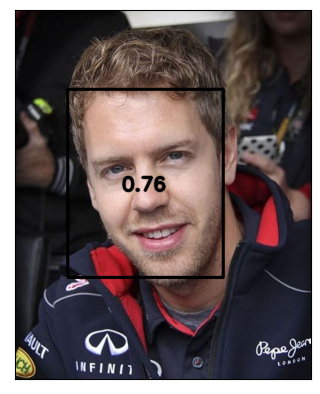

In [33]:
image = cv2.imread(datapath + 'test/071_5d394300.jpg') # change to exisiting image

print(image)

detections = model.detect(image, threshold=0.6)

for detection in detections:
  print(detection)

show_detections(image, detections, thickness=4)